In [81]:
import os
import sys
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from osgeo import gdal, osr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import shape
from rasterstats import zonal_stats
from rasterstats import zonal_stats as rs_zonal_stats
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [82]:
country = 'India'

admin_folder = Path(r'AOI/')
ward_file = Path(r'AOI/mumbai_wards.shp')
output_folder = Path(r'Output')
input_raster = Path(r'Raster/EuropeanAsia_Ta_SVCMsp_2020TMIN_150.tif')
city = 'Mumbai'
prepend_file_text = 'air_temp'


In [83]:


def clipdata_era(admin_folder, input_raster, output_folder, city):
    for file in os.listdir(admin_folder):
        if file.endswith(".shp"):
            print(f"Processing {file}")

            # Read shapefile
            shapefile_path = os.path.join(admin_folder, file)
            features = gpd.read_file(shapefile_path)
            print(f"Admin file CRS: {features.crs}")

            # Check if the geometries are valid
            if not all(features.is_valid):
                print("Invalid geometries found in shapefile. Attempting to fix...")
                features = features.buffer(0)
                if not all(features.is_valid):
                    print("Failed to fix geometries.")
                    continue

            # Convert to list of geometries
            geometries = features['geometry'].tolist()

            # Open raster file
            with rasterio.open(input_raster) as src:
                print(f"Raster file CRS: {src.crs}")

                # Check CRS alignment
                if features.crs != src.crs:
                    print("CRS mismatch between raster and shapefile. Aligning CRS...")
                    features = features.to_crs(src.crs)
                    geometries = features['geometry'].tolist()

                try:
                    # Clip raster with features
                    out_image, out_transform = mask(src, geometries, crop=True)
                except ValueError as e:
                    print(f"Error during clipping: {e}")
                    continue

                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform
                })

                # Construct output file paths with city name in the filename
                prepend_file_text = f'2024_'+f'{city}'
                output_file = os.path.join(output_folder, prepend_file_text + '.tif')
                csv_output_file = os.path.join(output_folder, prepend_file_text+ '.csv')

                # Save clipped raster to file
                with rasterio.open(output_file, "w", **out_meta) as dest:
                    dest.write(out_image)

                print(f"Saved clipped raster to {output_file}")

                # Convert clipped raster to CSV
                # Flatten the 2D array and generate coordinates
                array = out_image[0]  # Assuming a single band for simplicity
                rows, cols = np.indices(array.shape)
                flat_array = array.flatten()
                flat_rows = rows.flatten()
                flat_cols = cols.flatten()
                
                # Get the spatial coordinates
                x_coords, y_coords = rasterio.transform.xy(out_transform, flat_rows, flat_cols)

                df = pd.DataFrame({
                    'x': x_coords,
                    'y': y_coords,
                    'value': flat_array
                })

                df = df[df['value'] > 0]

                # Save DataFrame to CSV
                df.to_csv(csv_output_file, index=False)
                print(f"Saved clipped raster data to CSV {csv_output_file}")

                # Plot the clipped image
                plt.figure(figsize=(10, 10))
                plt.imshow(out_image[0], cmap='viridis')
                plt.colorbar()
                plt.title(f'Clipped Raster Image for {city}')
                plt.xlabel('Column Index')
                plt.ylabel('Row Index')
                plt.show()



Processing mumbai_wards.shp
Admin file CRS: EPSG:4326
Raster file CRS: PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
CRS mismatch between raster and shapefile. Aligning CRS...
Saved clipped raster to Output/2024_air_temp.tif
Saved clipped raster data to CSV Output/2024_air_temp.csv


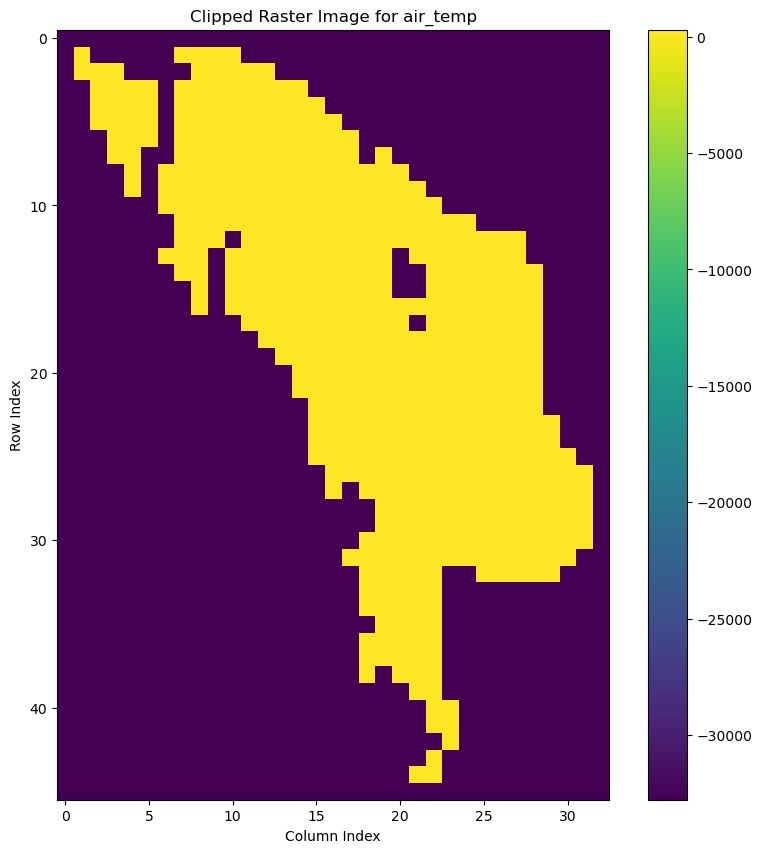

Processing Mumbai.shp
Admin file CRS: EPSG:4326
Raster file CRS: PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
CRS mismatch between raster and shapefile. Aligning CRS...
Saved clipped raster to Output/2024_air_temp.tif
Saved clipped raster data to CSV Output/2024_air_temp.csv


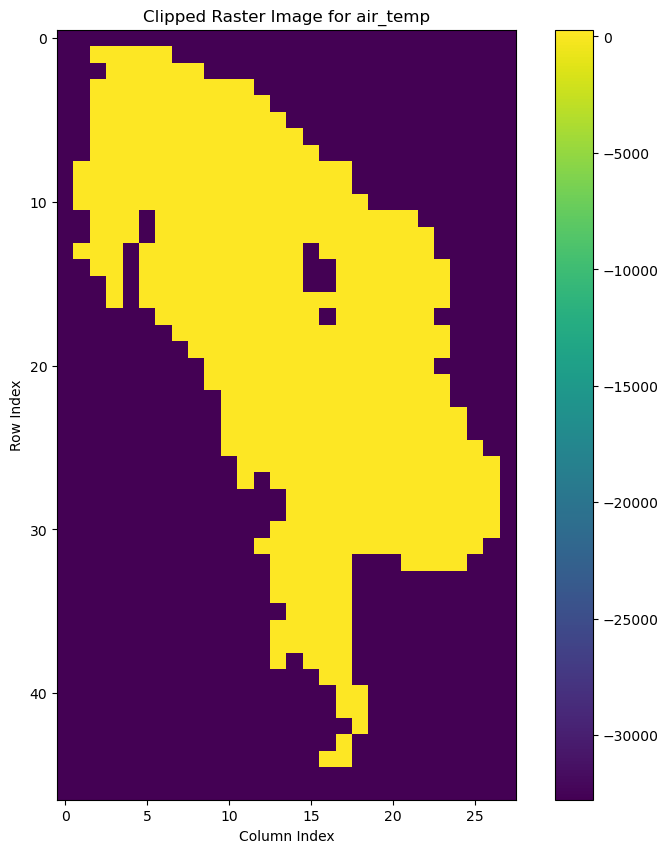

In [84]:
mum_clip = clipdata_era(admin_folder,input_raster,output_folder,prepend_file_text)

In [97]:
def perform_zonal_stats(tif_path, ward_file, output_csv, output_png):
    # Load shapefile and raster
    wards = gpd.read_file(ward_file)
    
    # Reproject shapefile to EPSG:4326 if needed
    if wards.crs != 'EPSG:4326':
        wards = wards.to_crs(epsg=4326)
    
    # Load raster and reproject to EPSG:4326 if needed
    with rasterio.open(tif_path) as src:
        if src.crs != 'EPSG:4326':
            transform, width, height = calculate_default_transform(
                src.crs, 'EPSG:4326', src.width, src.height, *src.bounds
            )
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': 'EPSG:4326',
                'transform': transform,
                'width': width,
                'height': height
            })
            
            # Define output file path for reprojected raster
            output_tif = 'Output/reprojected_temp_raster.tif'
            
            with rasterio.open(output_tif, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs='EPSG:4326',
                        resampling=Resampling.nearest,
                    )
    
    # Perform zonal statistics
    stats = rs_zonal_stats(wards, output_tif, stats=['mean'], geojson_out=True)
    
    # Convert to GeoDataFrame
    gdf_stats = gpd.GeoDataFrame.from_features(stats)
    
    # Extract mean values and join with original shapefile
    wards['mean'] = gdf_stats['mean']/10 

    
    # Save to CSV
    wards[['geometry', 'mean']].to_csv(output_csv, index=False)
    
    # Plot choropleth map
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    wards.plot(column='mean', ax=ax, legend=True, cmap='YlOrRd')
    ax.set_title('Choropleth Map of Mean Values per Ward')
    
    # Save choropleth map
    plt.savefig(output_png, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"CSV saved to {output_csv}")
    print(f"Choropleth map saved to {output_png}")

# Paths to your files
tif_path = 'Output/2024_air_temp.tif'
output_csv = 'mean_airtemp_values.csv'
output_png = 'choropleth_map_airtemp.png'

# Perform zonal statistics and generate CSV and choropleth map
perform_zonal_stats(tif_path, ward_file, output_csv, output_png)

CSV saved to mean_airtemp_values.csv
Choropleth map saved to choropleth_map_airtemp.png
